## EDA on Yelp Review Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process

### 0. Load Datasets
`reviews`, `users`, `business`: Extract relevant attributes from respective datasets

In [2]:
df_reviews = pd.read_csv('./Cleaned Files/Cleaned_Filtered_Yelp_Reviews.csv')
df_users = pd.read_json('./Yelp JSON/yelp_dataset/yelp_academic_dataset_user.json', lines=True)
df_biz = pd.read_csv('./Cleaned Files/Cleaned-Yelp-Businesses-v4.csv')
print(f'reviews has shape {df_reviews.shape} and columns:')
print(df_reviews.columns.tolist())
print(f'users has shape {df_users.shape} and columns:')
print(df_users.columns.tolist())
print(f'biz has shape {df_biz.shape} and columns:')
print(df_biz.columns.tolist())

df_reviews['year'] = pd.to_datetime(df_reviews['date']).dt.year

reviews has shape (1625648, 9) and columns:
['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']
users has shape (1987897, 22) and columns:
['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']
biz has shape (52268, 50) and columns:
['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories', 'accepts_credit_cards', 'price_range', 'parking', 'takeout', 'wifi', 'delivery', 'outdoor_seating', 'reservations', 'good_for_groups', 'alcohol', 'attire', 'noise_level', 'table_service', 'happy_hour', 'drive_thru', 'smoking', 'byob', 'Monday_opening', 'Monday_closing', 'Monday_hours_open', 'Tuesd

### 1. EDA

#### (a) Review Characteristics (mainly from `df_reviews`)
- **Review Counts**: 
    - Total number of reviews (by years)
    - Number of reviews per business
- **Review Ratings**: 
    - Spread of review ratings
- **Review Engagement**: Reviews can be voted to be `useful`, `funny`, or `cool` by other users. These votes may capture subtle tones/nuances (e.g., sarcasm, jokes) that pre-trained sentiment analysis models may not perform well in processing. 
    - Share of reviews with non-zero review engagement, spread of engagement among non-zero engagements
    - Average ratings of reviews with zero / non-zero review engagement

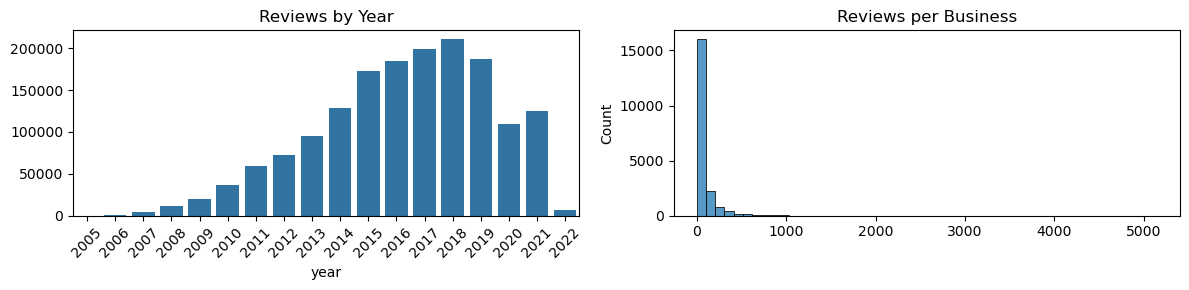

In [3]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
yearly_counts = df_reviews['year'].value_counts().sort_index()
sns.barplot(x=yearly_counts.index, y=yearly_counts.values)
plt.title('Reviews by Year')
plt.xticks(rotation=45) # Increasing trend in reviews, but dip in 2019- (possibly due to COVID-19 pandemic), and incomplete data in 2022

plt.subplot(1, 2, 2)
business_review_counts = df_reviews.groupby('business_id').size()
sns.histplot(business_review_counts, bins=50)
plt.title('Reviews per Business')
plt.tight_layout()
plt.show()

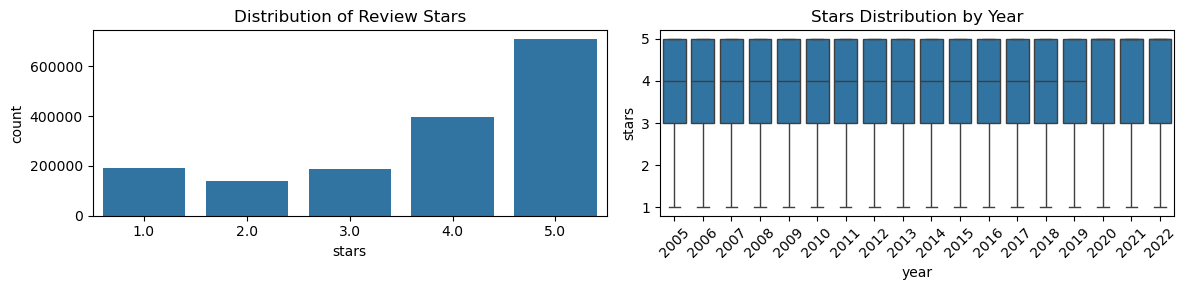

,year,avg,p10,p25,p50,p75,p90
0,2005,3.983936,3.0,3.0,4.0,5.0,5.0
1,2006,3.923913,2.3,3.0,4.0,5.0,5.0
2,2007,3.802871,2.0,3.0,4.0,5.0,5.0
3,2008,3.756242,2.0,3.0,4.0,5.0,5.0
4,2009,3.680921,2.0,3.0,4.0,5.0,5.0
5,2010,3.699940,2.0,3.0,4.0,5.0,5.0
6,2011,3.690481,2.0,3.0,4.0,5.0,5.0
7,2012,3.685111,2.0,3.0,4.0,5.0,5.0
8,2013,3.693429,2.0,3.0,4.0,5.0,5.0
9,2014,3.750816,1.0,3.0,4.0,5.0,5.0


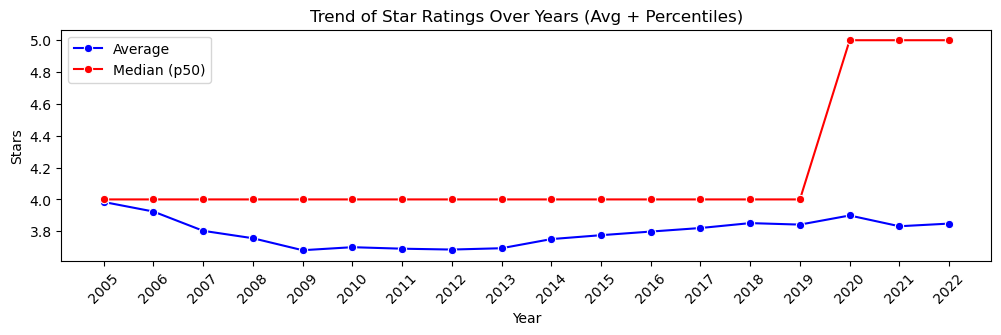

In [4]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.countplot(x='stars', data=df_reviews)
plt.title('Distribution of Review Stars') # Mostly 5 star reviews (possible selection bias since people usually only post when they have gd/bad exp)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_reviews, x='year', y='stars')
plt.title('Stars Distribution by Year') # Broadly similar across years, with exception of 2020-
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

percentiles_df = df_reviews.groupby('year')['stars'].agg(
    avg=lambda x: x.mean(),
    p10=lambda x: x.quantile(0.10),
    p25=lambda x: x.quantile(0.25),
    p50=lambda x: x.quantile(0.50),
    p75=lambda x: x.quantile(0.75),
    p90=lambda x: x.quantile(0.90)
).reset_index()
display(percentiles_df)

plt.figure(figsize=(12, 3))
sns.lineplot(data=percentiles_df, x='year', y='avg', label='Average', marker='o', color='blue')
sns.lineplot(data=percentiles_df, x='year', y='p50', label='Median (p50)', marker='o', color='red')
plt.xticks(ticks=percentiles_df['year'].unique(), rotation=45) 
plt.title('Trend of Star Ratings Over Years (Avg + Percentiles)')
plt.xlabel('Year')
plt.ylabel('Stars')
plt.legend()
plt.show()

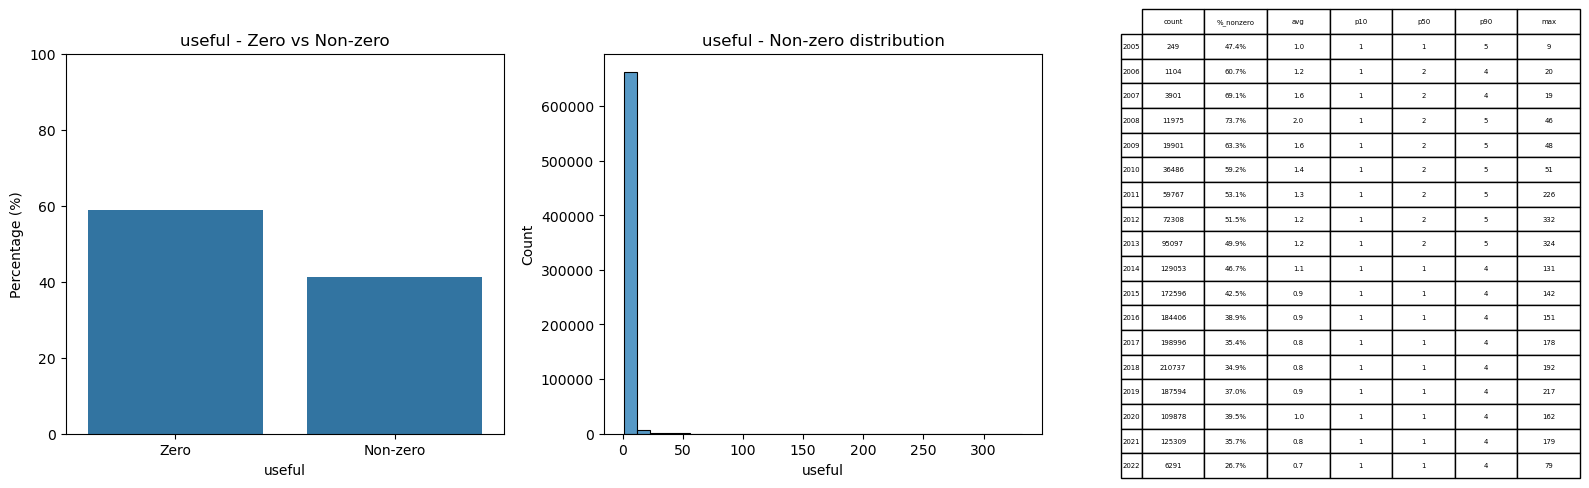

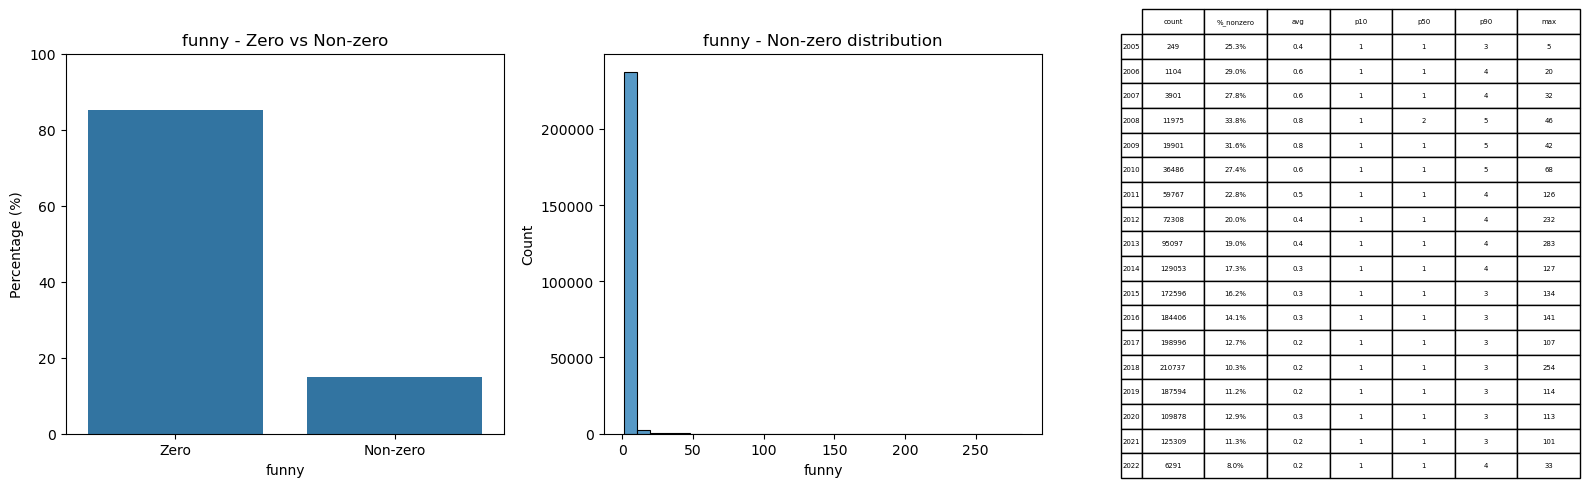

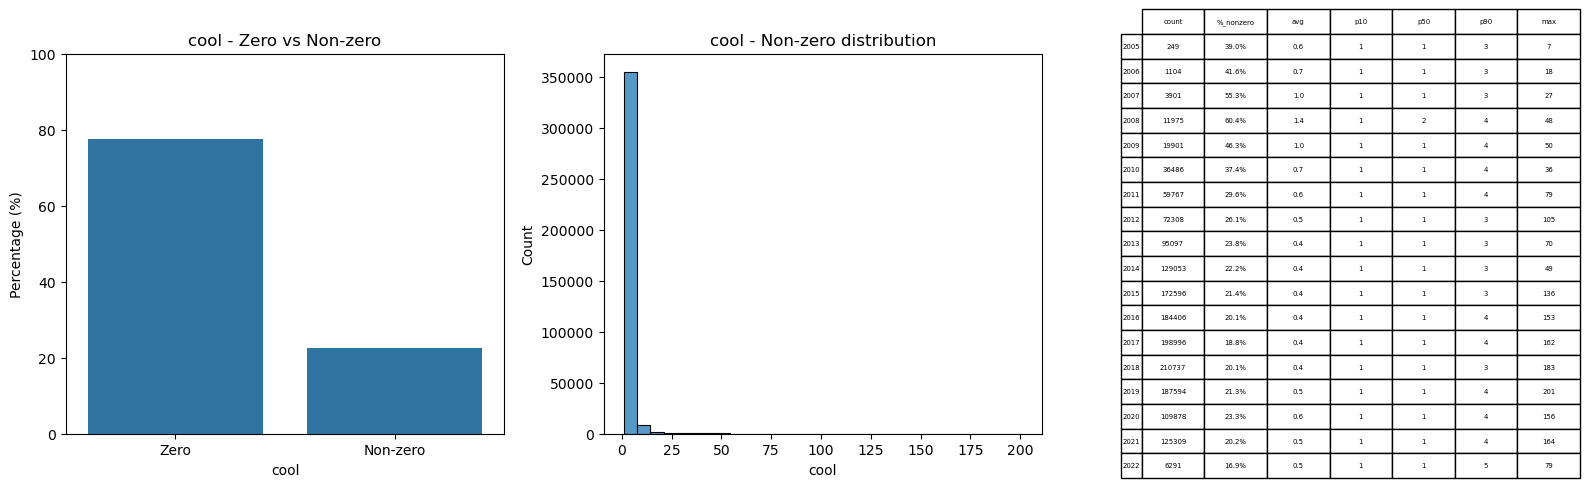

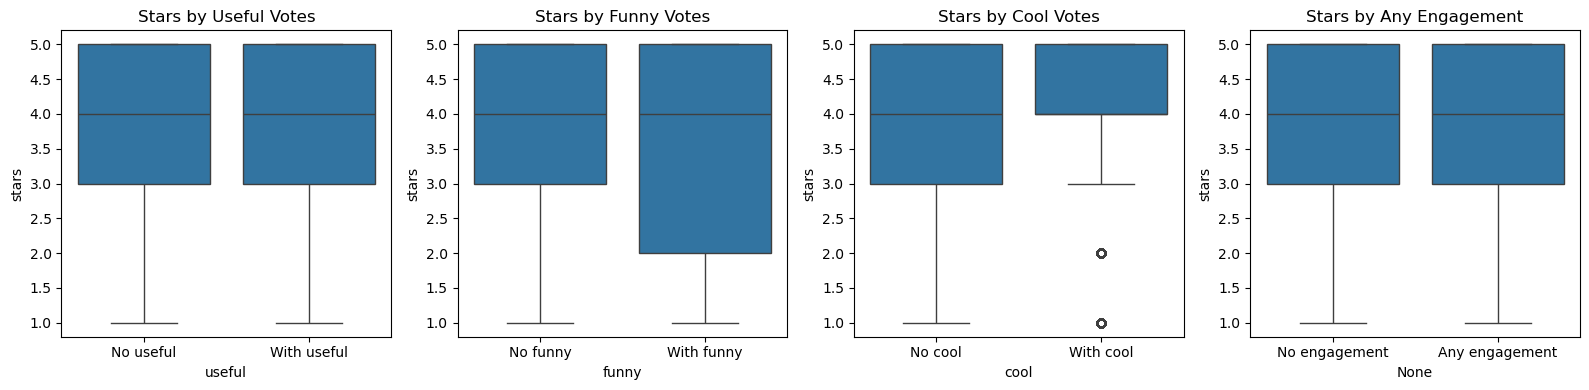

In [5]:
engagement_cols = ['useful', 'funny', 'cool']
df_reviews['year'] = pd.to_datetime(df_reviews['date']).dt.year

for col in engagement_cols:
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 3, 1)
    counts = (df_reviews[col] > 0).value_counts(normalize=True) * 100
    ax = sns.barplot(x=counts.index.map({True: 'Non-zero', False: 'Zero'}), y=counts.values)
    plt.ylim(0, 100)
    plt.ylabel('Percentage (%)')
    plt.title(f'{col} - Zero vs Non-zero')
    
    plt.subplot(1, 3, 2)
    sns.histplot(df_reviews[df_reviews[col] >= 1][col], bins=30)
    plt.title(f'{col} - Non-zero distribution')
    
    plt.subplot(1, 3, 3)
    stats = df_reviews.groupby('year')[col].agg([
        ('count', 'count'),
        ('%_nonzero', lambda x: f'{(x>0).mean():.1%}'),
        ('avg', lambda x: f'{x.mean():.1f}'),
        ('p10', lambda x: f'{x[x>0].quantile(0.1):.0f}'),
        ('p50', lambda x: f'{x[x>0].quantile(0.5):.0f}'),
        ('p90', lambda x: f'{x[x>0].quantile(0.9):.0f}'),
        ('max', 'max')
    ])
    
    plt.axis('off')
    table = plt.table(cellText=stats.values,
                     rowLabels=stats.index,
                     colLabels=stats.columns,
                     loc='center',
                     cellLoc='center')
    table.set_fontsize(20)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sns.boxplot(data=df_reviews, x=df_reviews['useful'] > 0, y='stars')
plt.xticks([0, 1], ['No useful', 'With useful'])
plt.title('Stars by Useful Votes')

plt.subplot(1, 4, 2)
sns.boxplot(data=df_reviews, x=df_reviews['funny'] > 0, y='stars')
plt.xticks([0, 1], ['No funny', 'With funny'])
plt.title('Stars by Funny Votes')

plt.subplot(1, 4, 3)
sns.boxplot(data=df_reviews, x=df_reviews['cool'] > 0, y='stars')
plt.xticks([0, 1], ['No cool', 'With cool'])
plt.title('Stars by Cool Votes')

plt.subplot(1, 4, 4)
any_engagement = (df_reviews[engagement_cols] > 0).any(axis=1)
sns.boxplot(data=df_reviews, x=any_engagement, y='stars')
plt.xticks([0, 1], ['No engagement', 'Any engagement'])
plt.title('Stars by Any Engagement')

plt.tight_layout()
plt.show()

### (c) User Characteristics
- **Average Stars**: Check how average stars from `df_users` differs from aggregated average stars from `df_reviews` over 2005-2022
- **Review Counts, Star Spread**:
    - Distribution of number of reviews per user / spread of star ratings per user
    - Check if there is a pattern between number of reviews a user has posted and the average star rating / spread of star ratings per user
- **Location of Businesses Reviewed**: 
    - Pull business location information (city, state) from `df_biz`, clean city/state, plot distribution of the number of unique city-states per user 

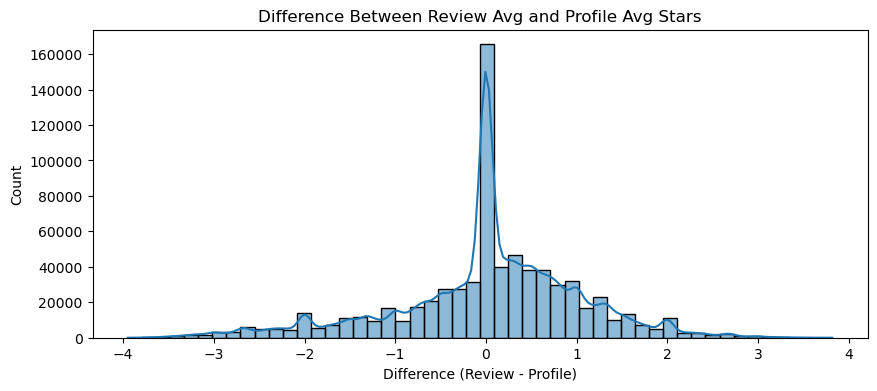

,count,mean,std,min,p10,p25,p50,p75,p90,max
diff,728942.0,0.028844,1.035655,-3.95,-1.38,-0.368544,0.0,0.62,1.25,3.82


In [ ]:
user_avg_from_reviews = df_reviews.groupby('user_id')['stars'].mean()
combined_avg = pd.merge(user_avg_from_reviews, df_users[['user_id', 'average_stars']], on='user_id')
combined_avg['diff'] = combined_avg['stars'] - combined_avg['average_stars']

plt.figure(figsize=(10, 4))
sns.histplot(combined_avg['diff'], bins=50, kde=True)
plt.title('Difference Between Review Avg and Profile Avg Stars') 
plt.xlabel('Difference (Review - Profile)')
plt.show()

display(combined_avg['diff']
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).to_frame().T
    .rename(columns={'10%': 'p10', '25%': 'p25', '50%': 'p50', '75%': 'p75', '90%': 'p90'}))

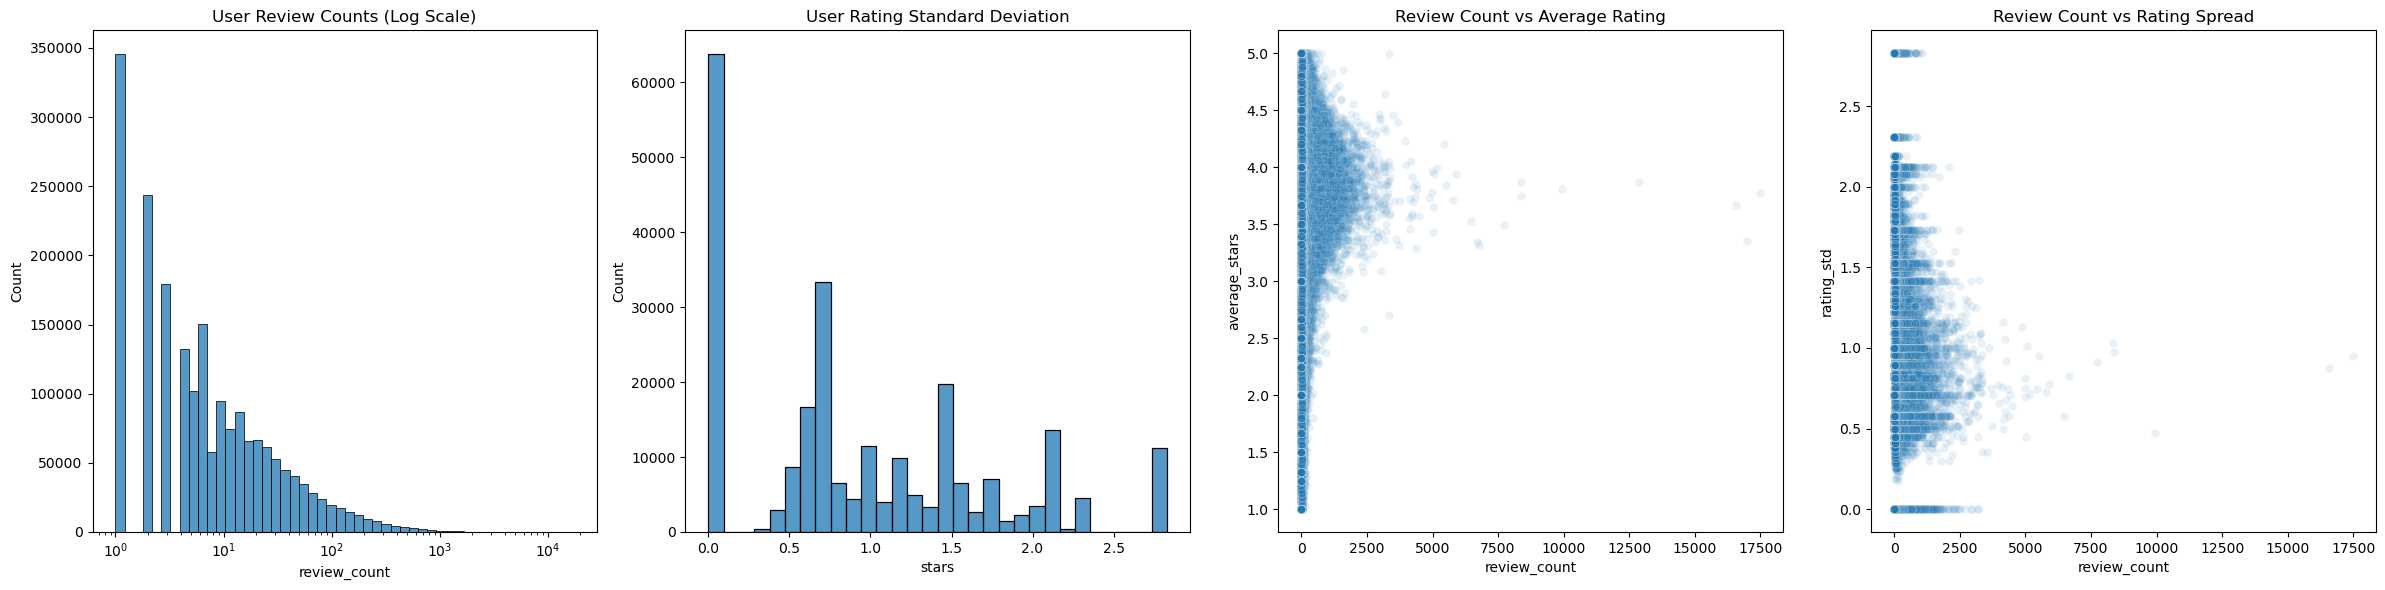

In [ ]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
sns.histplot(df_users['review_count'], bins=50, log_scale=True)
plt.title('User Review Counts (Log Scale)')

plt.subplot(1, 4, 2)
user_rating_std = df_reviews.groupby('user_id')['stars'].std().dropna()
sns.histplot(user_rating_std, bins=30)
plt.title('User Rating Standard Deviation')

plt.subplot(1, 4, 3)
sns.scatterplot(data=df_users, x='review_count', y='average_stars', alpha=0.1)
plt.title('Review Count vs Average Rating')

plt.subplot(1, 4, 4)
merged_users = pd.merge(df_users, user_rating_std.rename('rating_std'), on='user_id')
sns.scatterplot(data=merged_users, x='review_count', y='rating_std', alpha=0.1)
plt.title('Review Count vs Rating Spread')
plt.tight_layout()
plt.show()

In [ ]:
def clean_cities_with_state(city_state_df, threshold=85):
    cleaned = {}
    city_state_tuples = list(city_state_df.itertuples(index=False, name=None))
    for city, state in city_state_tuples:
        existing = [k for k in cleaned.keys() if k[1] == state]
        
        if existing:
            match, score = process.extractOne(city, [x[0] for x in existing], scorer=fuzz.token_set_ratio)
            if score >= threshold:
                key = next(k for k in existing if k[0] == match)
                cleaned[key].append(city)
                continue
        cleaned[(city, state)] = []
    return cleaned

In [ ]:
merged = pd.merge(df_reviews, df_biz[['business_id', 'city', 'state']], on='business_id')
city_state_df = merged[['city', 'state']].drop_duplicates()

print('\nList of all cities before cleaning (sorted alphabetically):')
print(sorted(merged['city'].dropna().unique(), key=lambda x: str(x).lower()))
print('\nList of all states before cleaning (sorted alphabetically):')
print(sorted(merged['state'].dropna().unique(), key=lambda x: str(x).lower()))

print(f'\nUnique city-state pairs before cleaning: {len(city_state_df)}')

cleaned_cities = clean_cities_with_state(city_state_df)
city_mapping = {orig: clean[0] for clean, originals in cleaned_cities.items() for orig in [clean[0]] + originals}
merged['clean_city'] = merged['city'].map(city_mapping)
merged['city_state'] = merged['clean_city'] + ', ' + merged['state']

print(f'Unique city-state pairs after cleaning: {len(cleaned_cities)}')
print(f'Reduction of {len(city_state_df) - len(cleaned_cities)} city-state pairs')


List of all cities before cleaning (sorted alphabetically):
['Abington', 'Abington Township', 'Affton', 'Aldan', 'Alton', 'Ambler', 'Antioch', 'Apollo Beach', 'Arabi', 'Ardmore', 'Arnold', 'Ashland', 'Ashland City', 'Aston', 'Atco', 'Audubon', 'Audubon ', 'Avon', 'Avondale', 'Bala Cynwyd', 'Ballwin', 'Balm', 'Bargersville', 'Barrington', 'Bayonet Point', 'Beaumont', 'Beech Grove', 'Belle Chase', 'Belle Chasse', 'Belle Meade', 'Belleair Blf', 'Belleair Bluffs', 'Belleville', 'Bellevue', 'Bellmawr', 'Bellville', 'Belmont Hills', 'Bensalem', 'Berkeley', 'Berlin', 'Berlin Township', 'Berry Hill', 'Berwyn', 'Bethalto', 'Bethel', 'Bethel Township', 'Beverly', 'Birchrunville', 'Blackwood', 'Blue Bell', 'Blvd', 'Boise', 'Boise City', 'Boone', 'Boothwyn', 'Bordentown', 'Boyertown', 'Brandon', 'Breckenridge Hills', 'Brentwood', 'Bridge City', 'Bridgeport', 'Bridgeton', 'Bristol', 'Bristol Twp', 'Brookhaven', 'Brooklawn', 'Broomall', 'Brownsburg', 'Bryn Athyn', 'Bryn Mawr', 'Buckingham', 'Bucks'

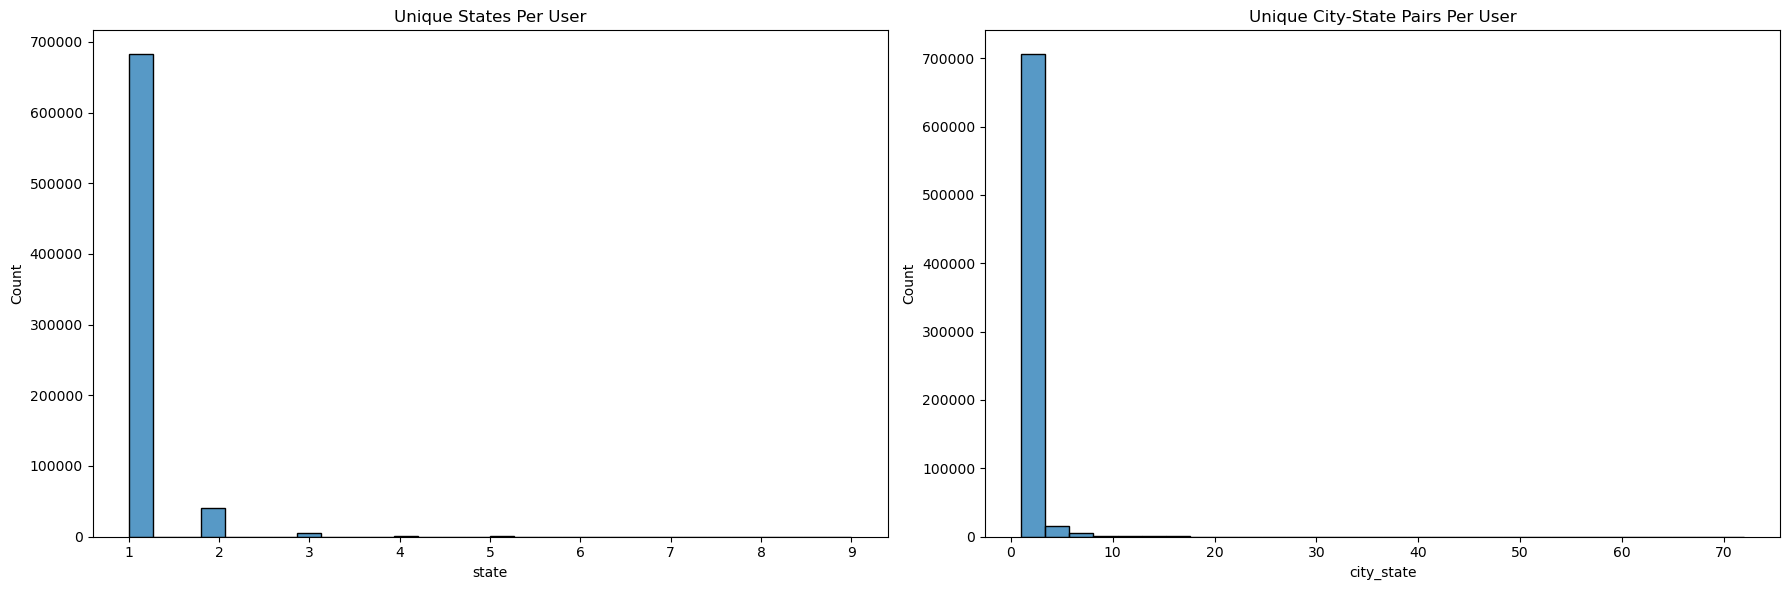

,count,mean,std,min,p10,p25,p50,p75,p90,max
Unique States,728946.0,1.075578,0.315545,1.0,1.0,1.0,1.0,1.0,1.0,9.0
Unique City-States,728946.0,1.345463,1.100585,1.0,1.0,1.0,1.0,1.0,2.0,72.0


,Count
state,
PA,140887
FL,111547
LA,92748
TN,68223
MO,48163
IN,43036
CA,42280
AZ,39162
NV,37807


In [ ]:
states_per_user = merged.groupby('user_id')['state'].nunique()
city_states_per_user = merged.groupby('user_id')['city_state'].nunique()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.histplot(states_per_user, bins=30)
plt.title('Unique States Per User')

plt.subplot(1, 2, 2)
sns.histplot(city_states_per_user, bins=30)
plt.title('Unique City-State Pairs Per User')
plt.tight_layout()
plt.show()

geo_stats = pd.concat([
    states_per_user.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).rename('Unique States'),
    city_states_per_user.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).rename('Unique City-States')
], axis=1).T.rename(columns={'10%': 'p10', '25%': 'p25', '50%': 'p50', '75%': 'p75', '90%': 'p90'})

state_combinations = merged.groupby('user_id')['state'].agg(lambda x: ', '.join(sorted(set(x))))

display(geo_stats)
display(state_combinations.value_counts().head(10).to_frame('Count'))

### (b) Business Characteristics 
- **Average Stars**: Check how average stars from `df_biz` differs from aggregated average stars from `df_reviews` over 2005-2022
- **Review Counts, Average Stars, Spread of Star Ratings**: 
    - By Business Age/Years in Operation/Location

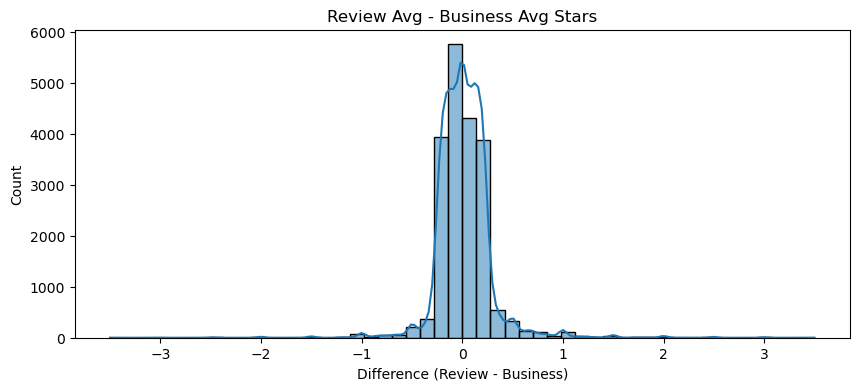

,count,mean,std,min,10%,25%,50%,75%,90%,max
stats,20074.0,0.019335,0.278929,-3.5,-0.21875,-0.130435,0.0,0.144994,0.233333,3.5


In [ ]:
merged = pd.merge(df_reviews, df_biz, on='business_id')
biz_stars = merged.groupby('business_id')[['stars_x', 'stars_y']].mean()
biz_stars['diff'] = biz_stars['stars_x'] - biz_stars['stars_y']
biz_stars = biz_stars.rename(columns={'stars_x': 'review_avg', 'stars_y': 'biz_avg'})

plt.figure(figsize=(10, 4))
sns.histplot(biz_stars['diff'], bins=50, kde=True)
plt.title('Review Avg - Business Avg Stars')
plt.xlabel('Difference (Review - Business)')
plt.show()

display(biz_stars['diff']
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).to_frame('stats').T
    .rename(index={'10%': 'p10', '25%': 'p25', '50%': 'p50', '75%': 'p75', '90%': 'p90'}))

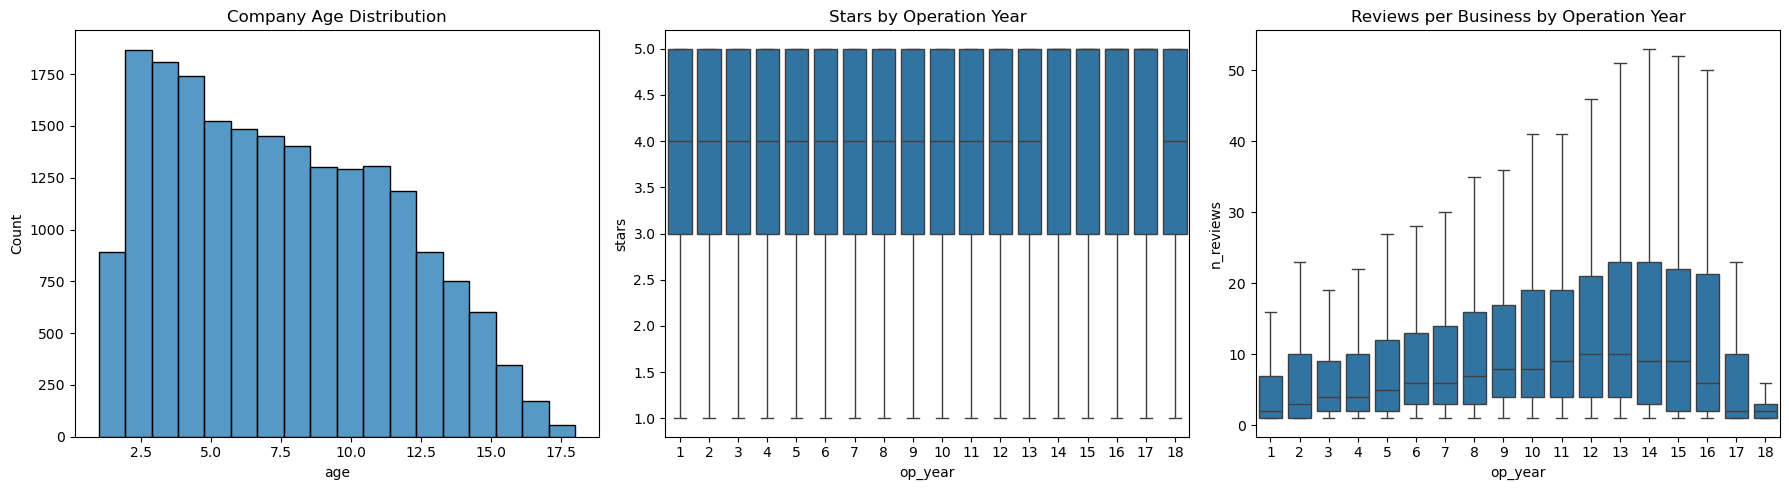

In [ ]:
biz_ops = df_reviews.groupby(['business_id', 'year'])['stars'].mean().groupby('business_id').cumcount().add(1).reset_index(name='op_year')
merged_ops = df_reviews.merge(biz_ops, on=['business_id', 'year'])
biz_age = df_reviews.groupby('business_id')['year'].agg(['min', 'max'])
biz_age['age'] = biz_age['max'] - biz_age['min'] + 1
reviews_per_biz = merged_ops.groupby(['business_id', 'op_year']).size().reset_index(name='n_reviews')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(biz_age['age'], bins=biz_age['age'].max(), kde=False)
plt.title('Company Age Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(data=merged_ops, x='op_year', y='stars', showfliers=False)
plt.title('Stars by Operation Year')

plt.subplot(1, 3, 3)
sns.boxplot(data=reviews_per_biz, x='op_year', y='n_reviews', showfliers=False)
plt.title('Reviews per Business by Operation Year')

plt.tight_layout()
plt.show()

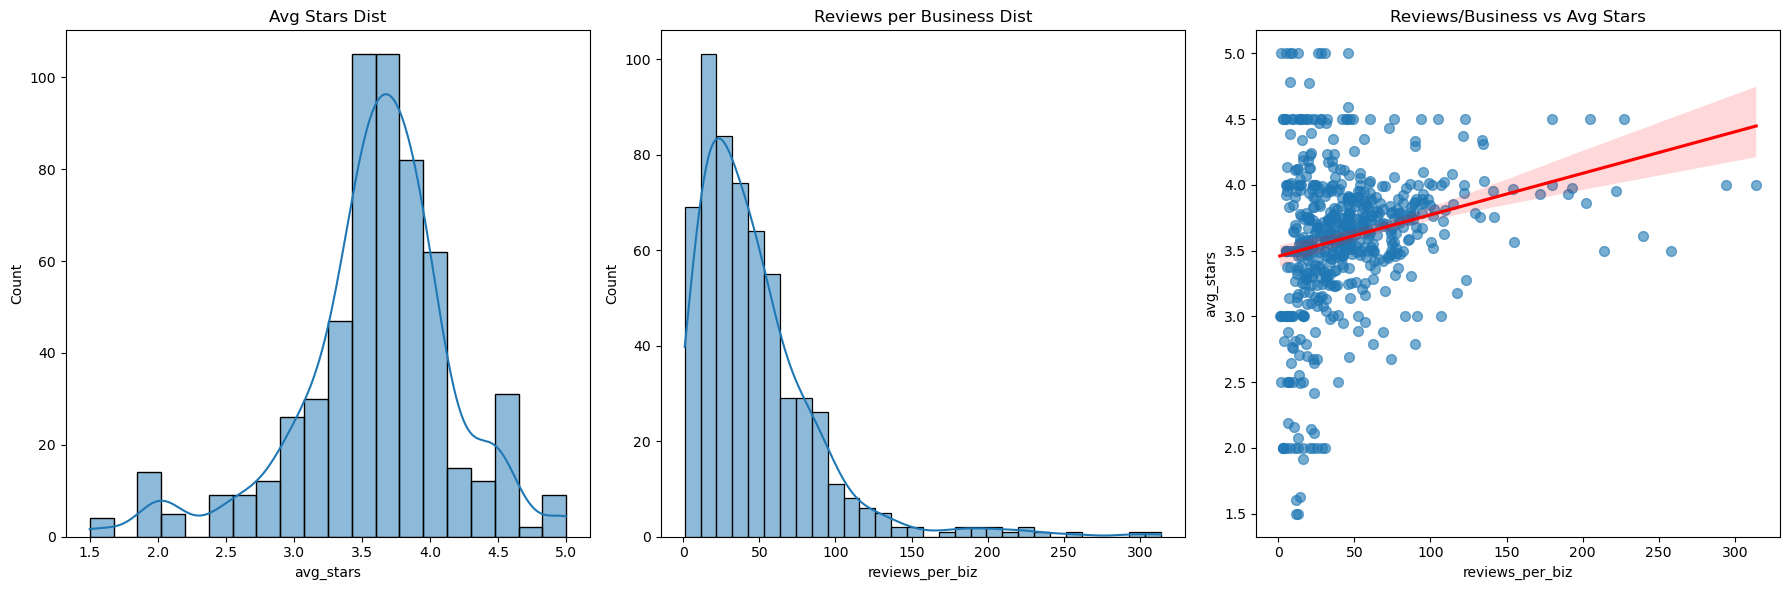

In [ ]:
merged['clean_city'] = merged['city'].map(
    {orig: clean[0] for clean, originals in clean_cities_with_state(merged[['city', 'state']].drop_duplicates()).items() 
    for orig in [clean[0]] + originals}
)

city_stats = merged.groupby(['clean_city', 'state']).agg(
    total_reviews=('business_id', 'count'),
    avg_stars=('stars_y', 'mean'),
    n_businesses=('business_id', 'nunique')
).assign(reviews_per_biz=lambda x: x['total_reviews'] / x['n_businesses'])

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(city_stats['avg_stars'], bins=20, kde=True)
plt.title('Avg Stars Dist')

plt.subplot(1, 3, 2)
sns.histplot(city_stats['reviews_per_biz'], bins=30, kde=True)
plt.title('Reviews per Business Dist')

plt.subplot(1, 3, 3)
sns.regplot(data=city_stats, x='reviews_per_biz', y='avg_stars', scatter_kws={'alpha': 0.6, 's': 50}, line_kws={'color': 'red'})
plt.title('Reviews/Business vs Avg Stars')

plt.tight_layout()
plt.show()